## Make Negative Account Balance
---

1. Naively write account balance related to negatives.
2. Add a negative transaction to the sampled accounts, rebuild transactions data.
    * this would effect some features.

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os, json
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from tqdm import tqdm
import copy

from src.utils import scale_scores
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

In [2]:
plt.style.use("seaborn")

In [3]:
with open('../../models/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb') as f:
    model = pickle.load(f)

In [4]:
path = "../../artifacts/20210313-negative-bal-on-ACHINDD/transactions_df.parquet"
transactions_df = pd.read_parquet(path)

In [5]:
transactions_df["type"].value_counts()

prev_trns    4493210
modified       48350
last_trn       48350
Name: type, dtype: int64

In [6]:
mdf_before = transactions_df[transactions_df.type == "last_trn"].sort_values("borrower_id")
mdf_after = transactions_df[transactions_df.type == "modified"].sort_values("borrower_id")

In [7]:
mdf_before.shape, mdf_after.shape

((48350, 135), (48350, 135))

#### Functions
---

In [8]:
def scale_scores(predictions):
    """
    Convert probability to score.
    """
    try:
        assert ((predictions >= 0) & (predictions <= 1)).all(), 'probability must be in range [0,1]'
    except AssertionError:
        raise

    # Formula parameters
    ALPHA = 631.9455383610933
    BETA = 30.812519272450654

    # Minimum and maximum values for validation
    MINIMUM = 300
    MAXIMUM = 850

    score = np.minimum(np.maximum(np.log(predictions / (1 - predictions)) * BETA + ALPHA, MINIMUM), MAXIMUM)
   
    return score


# update risk groups
# if splits needed: RG3 splits at 530, RG4 at 580

def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

### Process and Eval
---

##### Before

In [9]:
from utils import preprocess

In [10]:
features = model.feature_name_
mdf_before = preprocess(mdf_before)
mdf_before.head()

,index,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_comment,is_return,transaction_amount,account_ending_balance,card_present_ind,...,nr_returns_in_next_90d,bal_after_90d,target,target_with_restriction,indeterminate,keep,type,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
194793,1760225,2021-03-03 13:38:52,40,410000178332,POSDW,"AFFIRM *PAYMENT 855-423-3729, CA",False,-107.16,886.88,False,...,0.0,886.88,False,False,False,True,last_trn,1,-1.0,-1.0
1027697,8623360,2021-03-12 18:23:01,90,410001537288,DWTRF,Move Money to Vault 4508,False,-2000.00,1366.48,False,...,0.0,251871.25,False,False,False,True,last_trn,0,-1.0,-1.0
415296,3575756,2021-03-08 04:10:49,135,410000345005,ACHDWIN,SOFI SECURITIES ACH,False,-5000.00,10111.08,False,...,0.0,10133.81,False,False,False,True,last_trn,3,-1.0,-1.0
853625,7166033,2021-03-05 04:01:33,247,410001046039,ACHINDD,Accenture Federa PAYRLL DEP l Services LLC,False,1419.22,1489.22,False,...,0.0,1489.22,False,False,False,True,last_trn,6,-1.0,-1.0
192011,1738123,2021-03-10 03:59:18,284,410000174957,ACHDWIN,DOMINION ENERGY ELEC BILL ELECTRIC BILL,False,-198.34,114678.79,False,...,0.0,114678.79,False,False,False,True,last_trn,3,-1.0,-1.0


In [11]:
mdf_before['pred'] = model.predict_proba(mdf_before[features])[:,1]
mdf_before['score'] = scale_scores(mdf_before['pred'])
mdf_before['risk_group'] = get_risk_groups(mdf_before.score)

##### After

In [12]:
features = model.feature_name_
mdf_after = preprocess(mdf_after)
mdf_after.head()

,index,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_comment,is_return,transaction_amount,account_ending_balance,card_present_ind,...,nr_returns_in_next_90d,bal_after_90d,target,target_with_restriction,indeterminate,keep,type,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
4543972,1760225,2021-03-04 13:38:52,40,410000178332,POSDW,"AFFIRM *PAYMENT 855-423-3729, CA",False,-916.806801,886.88,False,...,0.0,886.88,False,False,False,True,modified,1,-1.0,-1.0
4552784,8623360,2021-03-13 18:23:01,90,410001537288,POSDW,Move Money to Vault 4508,False,-251885.349832,1366.48,False,...,0.0,251871.25,False,False,False,True,modified,1,-1.0,-1.0
4546413,3575756,2021-03-09 04:10:49,135,410000345005,POSDW,SOFI SECURITIES ACH,False,-10141.693718,10111.08,False,...,0.0,10133.81,False,False,False,True,modified,1,-1.0,-1.0
4550883,7166033,2021-03-06 04:01:33,247,410001046039,ACHDDIN,Accenture Federa PAYRLL DEP l Services LLC,True,-1525.972734,1489.22,False,...,0.0,1489.22,False,False,False,True,modified,4,-1.0,-1.0
4543937,1738123,2021-03-11 03:59:18,284,410000174957,POSDW,DOMINION ENERGY ELEC BILL ELECTRIC BILL,False,-114686.083731,114678.79,False,...,0.0,114678.79,False,False,False,True,modified,1,-1.0,-1.0


In [13]:
mdf_after['pred'] = model.predict_proba(mdf_after[features])[:,1]
mdf_after['score'] = scale_scores(mdf_after['pred'])
mdf_after['risk_group'] = get_risk_groups(mdf_after.score)

### Comparisons
---

In [14]:
trn_cols = """
transaction_amount
transaction_datetime
is_return
real_ending_balance
business_account_number
created_dt
transaction_code
business_account_number
borrower_id
is_dd
score
""".split()

In [15]:
mdf_before[trn_cols].head()

,transaction_amount,transaction_datetime,is_return,real_ending_balance,business_account_number,created_dt,transaction_code,business_account_number,borrower_id,is_dd,score
194793,-107.16,2021-03-03 13:38:52,False,886.88,410000178332,2021-02-26 13:25:26.868912,POSDW,410000178332,40,False,394.410355
1027697,-2000.00,2021-03-12 18:23:01,False,251871.25,410001537288,2021-02-01 19:33:15.028847,DWTRF,410001537288,90,False,410.310450
415296,-5000.00,2021-03-08 04:10:49,False,10133.81,410000345005,2020-02-12 21:02:14.232546,ACHDWIN,410000345005,135,False,489.264018
853625,1419.22,2021-03-05 04:01:33,False,1489.22,410001046039,2020-05-30 00:49:38.693354,ACHINDD,410001046039,247,True,394.409520
192011,-198.34,2021-03-10 03:59:18,False,114678.79,410000174957,2021-02-27 03:34:33.044968,ACHDWIN,410000174957,284,False,383.911470


In [16]:
mdf_after[trn_cols].head()

,transaction_amount,transaction_datetime,is_return,real_ending_balance,business_account_number,created_dt,transaction_code,business_account_number,borrower_id,is_dd,score
4543972,-916.806801,2021-03-04 13:38:52,False,-29.926801,410000178332,2021-02-26 13:25:26.868912,POSDW,410000178332,40,False,563.387020
4552784,-251885.349832,2021-03-13 18:23:01,False,-14.099832,410001537288,2021-02-01 19:33:15.028847,POSDW,410001537288,90,False,433.003463
4546413,-10141.693718,2021-03-09 04:10:49,False,-7.883718,410000345005,2020-02-12 21:02:14.232546,POSDW,410000345005,135,False,614.269147
4550883,-1525.972734,2021-03-06 04:01:33,True,-36.752734,410001046039,2020-05-30 00:49:38.693354,ACHDDIN,410001046039,247,True,392.773549
4543937,-114686.083731,2021-03-11 03:59:18,False,-7.293731,410000174957,2021-02-27 03:34:33.044968,POSDW,410000174957,284,False,542.995166


#### All Together
---

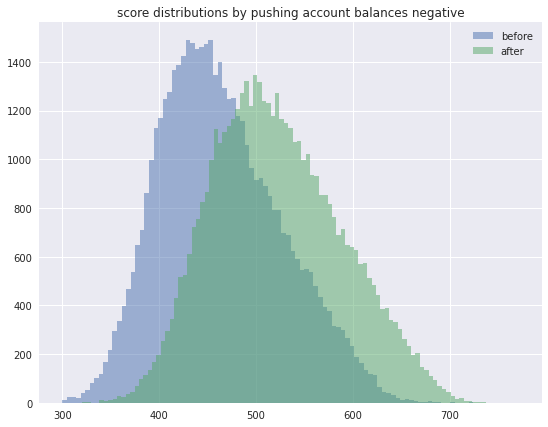

In [17]:
_ = plot_score_dist(mdf_before.score, mdf_after.score,
                    dev_label="before", prod_label="after", 
                    bins=100, title="score distributions by pushing account balances negative")

by going negative, model score generally moves up


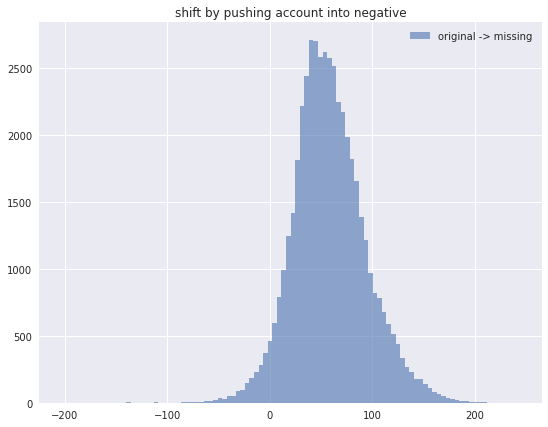

In [18]:
def plot_difference(expected_sequence, actual_sequence, 
                    figsize=(9,7), bins=10, label='exp - actual', title=''):
    """ Plot the distr of difference of two sequences 
    Two sequences should have the same size
    """
    assert(len(expected_sequence) == len(actual_sequence))
    fig = plt.figure(figsize=figsize)
    seq = np.array(expected_sequence) - np.array(actual_sequence)
    plt.hist(seq, alpha=0.6, bins=bins, label=label)
    plt.legend()
    plt.title(title)
    return fig

_ = plot_difference(mdf_after.score, mdf_before.score,  
                    bins=100, label="original -> missing",
                    title="shift by pushing account into negative")
print("by going negative, model score generally moves up")

Text(0.5, 1.0, 'Risk Group distributions')

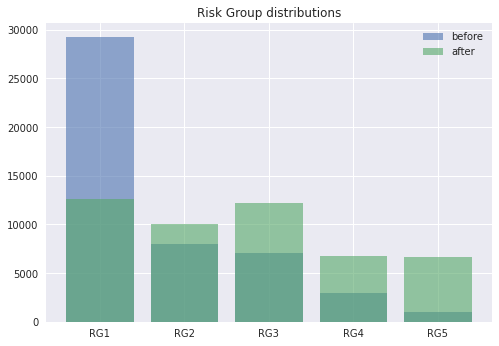

In [19]:
fig = plt.figure()
data = mdf_before.risk_group.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='before')
data = mdf_after.risk_group.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='after')
plt.legend()
plt.title('Risk Group distributions')

Text(0.5, 1.0, 'Risk Group difference by pushing an account negative')

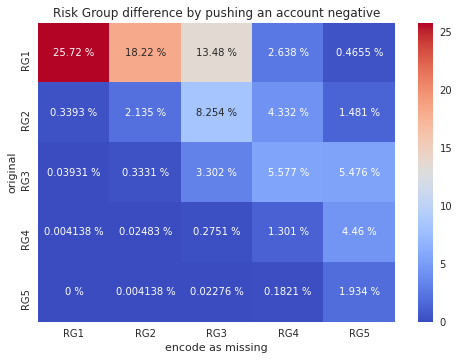

In [20]:
table = pd.merge(mdf_before[["business_account_number", "risk_group"]].astype(str),
                 mdf_after[["business_account_number", "risk_group"]].astype(str),
                 on="business_account_number", suffixes=("_original", "_as_missing"),
                 how="inner")
table = table[["risk_group_original", "risk_group_as_missing"]].value_counts(normalize=True).sort_index().reset_index()

table.columns = ['original', 'encode as missing', 'counts']
table = pd.pivot_table(table, values='counts', index='original', 
                       columns='encode as missing', fill_value=0) * 100 # to percentage
fig = plt.figure()
ax = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.4g')
for t in ax.texts: t.set_text(t.get_text() + " %")

plt.title('Risk Group difference by pushing an account negative')

In [21]:
mdf_after.transaction_code.value_counts()

POSDW           37866
DW               1931
ACHDDIN          1627
POSDD            1107
ACHINDD           677
DWPC              564
ACHDD             555
DDREWARDS         492
DDCASHBACK        431
DWCKCB            422
DWCRDBILLPAY      361
DDCRDBILLREF      358
DPNC              325
OTID              267
DDA2ATXFR         192
DWACHRET          186
DDMKT             178
DDPC              111
DWATMI            107
DDATMREFUND       107
DD                104
DDMBR             101
DDCK               88
DWCK               61
DWATM              28
DDCRDREWARD        27
DDINT              25
DDLYFTBONUS        17
DDTRF              15
ACHDWIN            10
ACHRC               5
DWBILLPAY           3
DCWI                2
Name: transaction_code, dtype: int64

#### Transaction type = `is_returned`

In [22]:
_mdf_after = mdf_after[mdf_after.is_return]
_mdf_before = mdf_before[mdf_before.business_account_number.isin(_mdf_after.business_account_number.unique())]

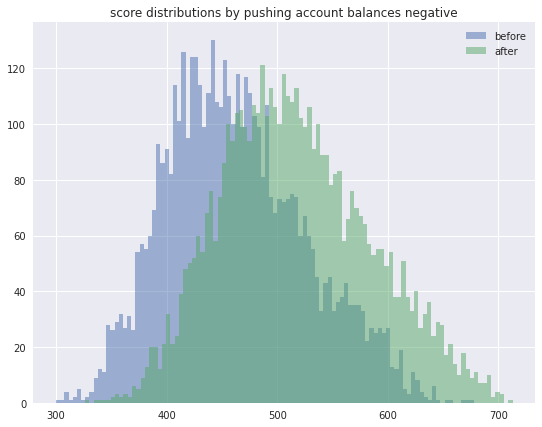

In [23]:
_ = plot_score_dist(_mdf_before.score, _mdf_after.score,
                    dev_label="before", prod_label="after", 
                    bins=100, title="score distributions by pushing account balances negative")

by going negative, model score generally moves up


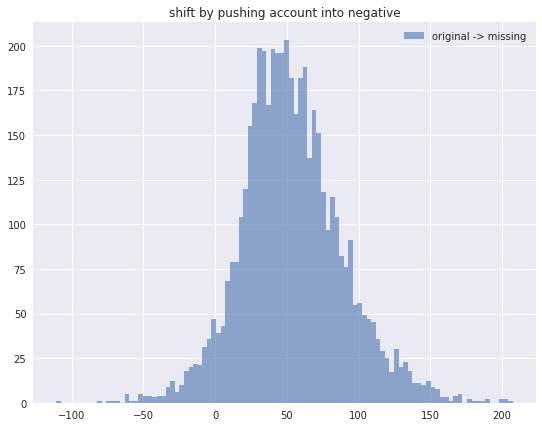

In [24]:
def plot_difference(expected_sequence, actual_sequence, 
                    figsize=(9,7), bins=10, label='exp - actual', title=''):
    """ Plot the distr of difference of two sequences 
    Two sequences should have the same size
    """
    assert(len(expected_sequence) == len(actual_sequence))
    fig = plt.figure(figsize=figsize)
    seq = np.array(expected_sequence) - np.array(actual_sequence)
    plt.hist(seq, alpha=0.6, bins=bins, label=label)
    plt.legend()
    plt.title(title)
    return fig

_ = plot_difference(_mdf_after.score, _mdf_before.score,  
                    bins=100, label="original -> missing",
                    title="shift by pushing account into negative")
print("by going negative, model score generally moves up")

Text(0.5, 1.0, 'Risk Group distributions')

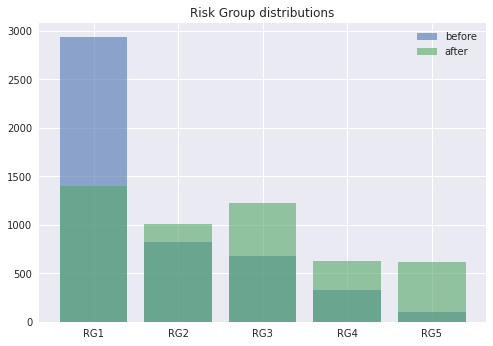

In [25]:
fig = plt.figure()
data = _mdf_before.risk_group.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='before')
data = _mdf_after.risk_group.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='after')
plt.legend()
plt.title('Risk Group distributions')

Text(0.5, 1.0, 'Risk Group difference by pushing an account negative')

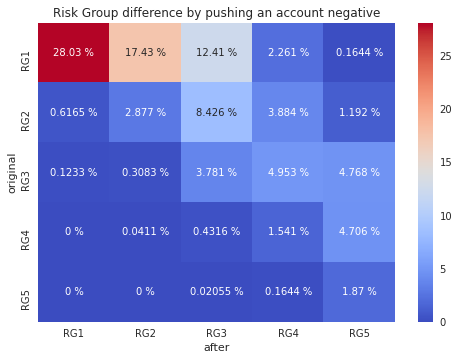

In [26]:
table = pd.merge(_mdf_before[["business_account_number", "risk_group"]].astype(str),
                 _mdf_after[["business_account_number", "risk_group"]].astype(str),
                 on="business_account_number", suffixes=("_original", "_as_missing"),
                 how="inner")
table = table[["risk_group_original", "risk_group_as_missing"]].value_counts(normalize=True).sort_index().reset_index()

table.columns = ['original', 'after', 'counts']
table = pd.pivot_table(table, values='counts', index='original', 
                       columns='after', fill_value=0) * 100 # to percentage
fig = plt.figure()
ax = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.4g')
for t in ax.texts: t.set_text(t.get_text() + " %")

plt.title('Risk Group difference by pushing an account negative')

Text(0.5, 1.0, 'Risk Group difference by pushing an account negative')

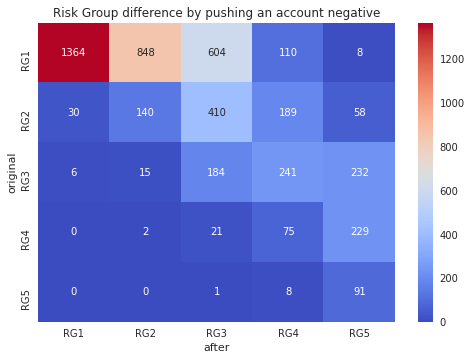

In [27]:
table = pd.merge(_mdf_before[["business_account_number", "risk_group"]].astype(str),
                 _mdf_after[["business_account_number", "risk_group"]].astype(str),
                 on="business_account_number", suffixes=("_original", "_as_missing"),
                 how="inner")
table = table[["risk_group_original", "risk_group_as_missing"]].value_counts(normalize=False).sort_index().reset_index()

table.columns = ['original', 'after', 'counts']
table = pd.pivot_table(table, values='counts', index='original', 
                       columns='after', fill_value=0) # to percentage
fig = plt.figure()
ax = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.4g')

plt.title('Risk Group difference by pushing an account negative')

#### Transaction type != `is_returned`

In [28]:
_mdf_after = mdf_after[~mdf_after.is_return]
_mdf_before = mdf_before[mdf_before.business_account_number.isin(_mdf_after.business_account_number.unique())]

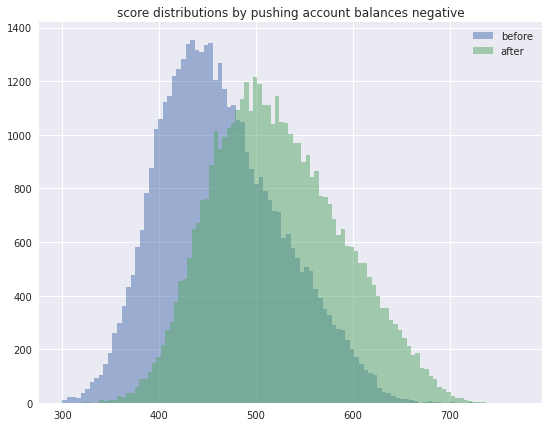

In [29]:
_ = plot_score_dist(_mdf_before.score, _mdf_after.score,
                    dev_label="before", prod_label="after", 
                    bins=100, title="score distributions by pushing account balances negative")

by going negative, model score generally moves up


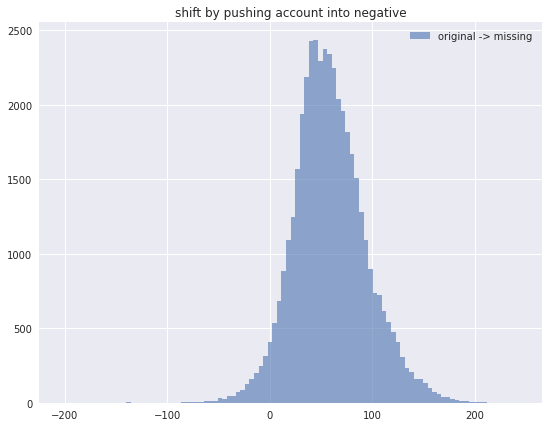

In [30]:
def plot_difference(expected_sequence, actual_sequence, 
                    figsize=(9,7), bins=10, label='exp - actual', title=''):
    """ Plot the distr of difference of two sequences 
    Two sequences should have the same size
    """
    assert(len(expected_sequence) == len(actual_sequence))
    fig = plt.figure(figsize=figsize)
    seq = np.array(expected_sequence) - np.array(actual_sequence)
    plt.hist(seq, alpha=0.6, bins=bins, label=label)
    plt.legend()
    plt.title(title)
    return fig

_ = plot_difference(_mdf_after.score, _mdf_before.score,  
                    bins=100, label="original -> missing",
                    title="shift by pushing account into negative")
print("by going negative, model score generally moves up")

Text(0.5, 1.0, 'Risk Group distributions')

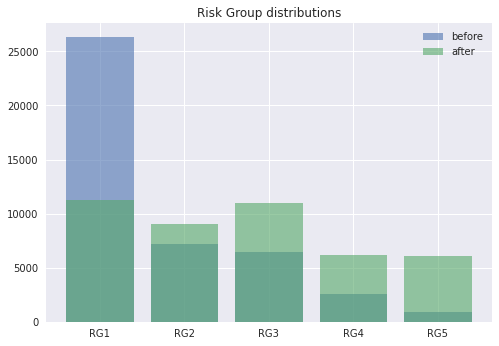

In [31]:
fig = plt.figure()
data = _mdf_before.risk_group.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='before')
data = _mdf_after.risk_group.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='after')
plt.legend()
plt.title('Risk Group distributions')

Text(0.5, 1.0, 'Risk Group difference by pushing an account negative')

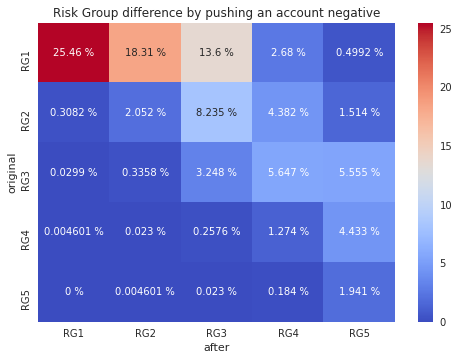

In [32]:
table = pd.merge(_mdf_before[["business_account_number", "risk_group"]].astype(str),
                 _mdf_after[["business_account_number", "risk_group"]].astype(str),
                 on="business_account_number", suffixes=("_original", "_as_missing"),
                 how="inner")
table = table[["risk_group_original", "risk_group_as_missing"]].value_counts(normalize=True).sort_index().reset_index()

table.columns = ['original', 'after', 'counts']
table = pd.pivot_table(table, values='counts', index='original', 
                       columns='after', fill_value=0) * 100 # to percentage
fig = plt.figure()
ax = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.4g')
for t in ax.texts: t.set_text(t.get_text() + " %")

plt.title('Risk Group difference by pushing an account negative')

Text(0.5, 1.0, 'Risk Group difference by pushing an account negative')

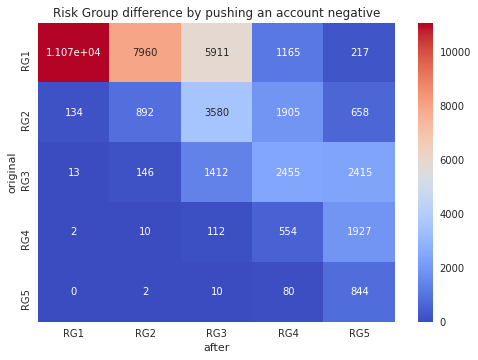

In [33]:
table = pd.merge(_mdf_before[["business_account_number", "risk_group"]].astype(str),
                 _mdf_after[["business_account_number", "risk_group"]].astype(str),
                 on="business_account_number", suffixes=("_original", "_as_missing"),
                 how="inner")
table = table[["risk_group_original", "risk_group_as_missing"]].value_counts(normalize=False).sort_index().reset_index()

table.columns = ['original', 'after', 'counts']
table = pd.pivot_table(table, values='counts', index='original', 
                       columns='after', fill_value=0) # to percentage
fig = plt.figure()
ax = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.4g')

plt.title('Risk Group difference by pushing an account negative')

### Segmented on account balance?
---

(0, 1000) 22778 22778
(1000, 2000) 5143 5143
(2000, 5000) 6233 6233
(5000, 10000) 4485 4485
(10000, inf) 9762 9762


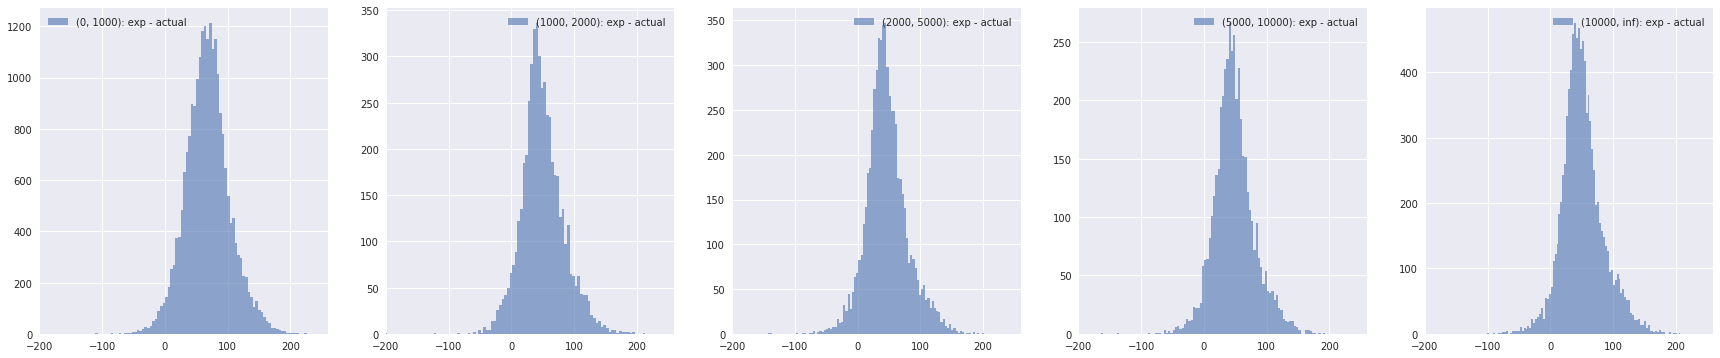

In [45]:
ranges = [(0, 1000), (1000, 2000), (2000, 5000), (5000, 10000), (10000, np.inf)]
fig, axs = plt.subplots(1, len(ranges), figsize=(6*len(ranges), 6))
for i, range_ in enumerate(ranges):
    pop_ind = mdf_before.real_ending_balance.between(*range_).values
    exp_seq = mdf_after.loc[pop_ind].score
    act_seq = mdf_before.loc[pop_ind].score
    print(range_, len(exp_seq), len(act_seq))
    seq = np.array(exp_seq) - np.array(act_seq)
    axs[i].hist(seq, alpha=0.6, bins=100, label=f'{range_}: exp - actual')
    axs[i].set_xlim(-200, 260)
    axs[i].legend()

### Segment on Risk Groups
---

RG1 29255
RG2 7996
RG3 7119
RG4 2932
RG5 1036


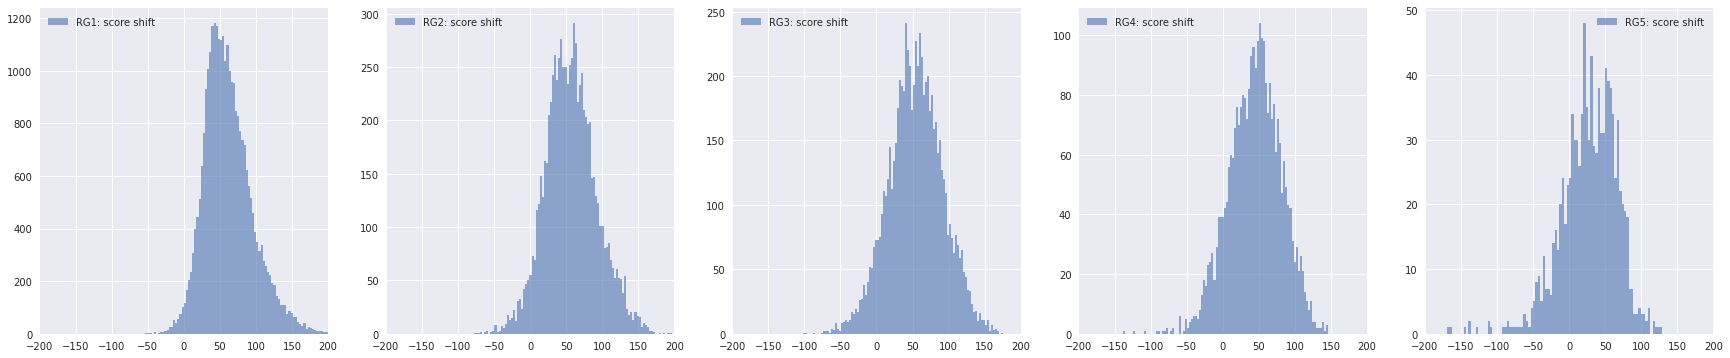

In [56]:
fig, axs = plt.subplots(1, 5, figsize=(30, 6))
for i, rg in enumerate(["RG1", "RG2", "RG3", "RG4", "RG5"]):
    exp_seq = mdf_after[(mdf_before.risk_group==rg).values].score
    act_seq = mdf_before[mdf_before.risk_group==rg].score
    print(rg, len(exp_seq))
    seq = np.array(exp_seq) - np.array(act_seq)
    axs[i].hist(seq, alpha=0.6, bins=100, label=f'{rg}: score shift')
    axs[i].legend()
    axs[i].set_xlim(-200, 200)